In [7]:
#PROPHET FORCASTING MODEL

In [8]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [9]:
df = pd.read_csv('Final Dataset.csv',
                   index_col=[0], parse_dates=[0])

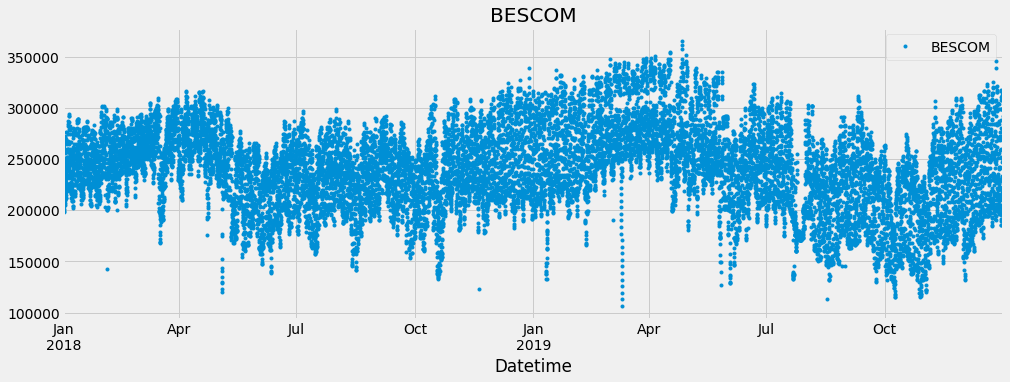

In [10]:
# Color pallete for plotting

_ = df.plot(style='.', figsize=(15,5), title='BESCOM')

In [11]:
df

,BESCOM
Datetime,
2018-01-01 00:00:00,211786.8638
2018-01-01 01:00:00,204022.4531
2018-01-01 02:00:00,198376.1782
2018-01-01 03:00:00,198870.6240
2018-01-01 04:00:00,201310.4045
...,...
2019-12-31 19:00:00,248972.7234
2019-12-31 20:00:00,232655.9861
2019-12-31 21:00:00,226721.6016


In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [ ]:
df

In [ ]:
df.index = df['Datetime']

In [ ]:
df

In [ ]:
df = df.drop(columns = "Datetime")

In [ ]:
df

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df.index)
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='BESCOM')

features_and_target = pd.concat([X, y], axis=1)

In [ ]:
features_and_target.head()

In [ ]:
#Plotting the Features to see trends
#Power demand has strong daily and seasonal properties.
#Day of week also seems to show differences in peaks

In [ ]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='BESCOM',
             height=5,
             plot_kws={'alpha':0.1, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [ ]:
#Train/Test Split

In [ ]:
split_date = '2019-10-01'
df_train = df[df.index <= split_date]
df_test = df[df.index > split_date]

In [ ]:
df_test \
    .rename(columns={'BESCOM': 'TEST SET'}) \
    .join(df_train.rename(columns={'BESCOM': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10,5), title='BESCOM', style='.')
plt.show()

In [ ]:
#Simple Prophet Model
#Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

In [ ]:
# Format data for prophet model using ds and y
df_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'BESCOM':'y'}).head()

In [ ]:
# Setup and train model
model = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
model.fit(df_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'BESCOM':'y'}))

In [ ]:
# Predict on training set with model
df_test_fcst = model.predict(df=df_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [ ]:
df_test_fcst.head()

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,
                 ax=ax)
plt.show()

In [ ]:
# Plot the components of the model
fig = model.plot_components(df_test_fcst)

In [ ]:
#Compare Forecast to Actuals

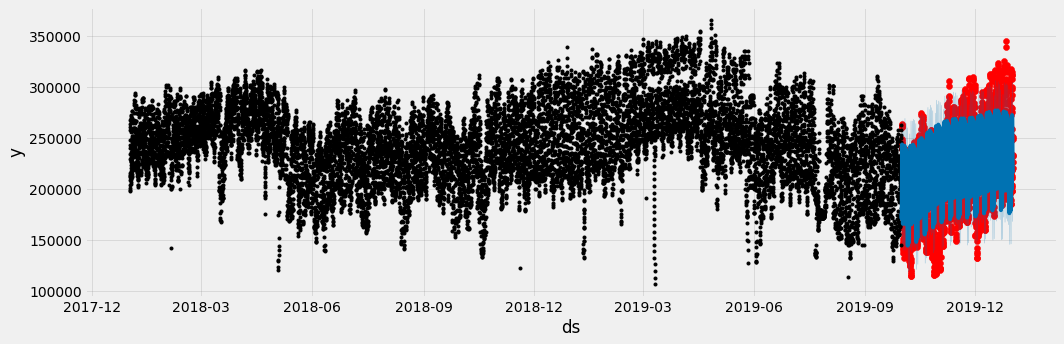

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['BESCOM'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

In [ ]:
#Error Metrics
#Our RMSE error is 585268008.80
#Our MAE error is 18806.95
#Our MAPE error is 9.65%

In [ ]:
mean_squared_error(y_true=df_test['BESCOM'],
                   y_pred=df_test_fcst['yhat'])

580659946.9573528

In [ ]:
mean_absolute_error(y_true=df_test['BESCOM'],
                   y_pred=df_test_fcst['yhat'])

18709.307178826977

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df_test['BESCOM'],
                   y_pred=df_test_fcst['yhat'])

9.544488490978182